In [15]:
%reload_ext autoreload
%autoreload 2

In [2]:
#export
from nb_002b import *

In [46]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

train_ds = ImageDataset.from_folder(PATH/'train')
valid_ds = ImageDataset.from_folder(PATH/'test')

x = train_ds[-4][0]

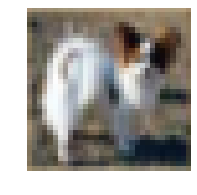

In [47]:
x.show()

# Perspective warping

## Introduction

Perspective warping is about bending or curving the image. This allows us to create multiple new images which contain the object but seen from a different perspective, thus enriching our original dataset.
Mathematically, warping is finding the function that maps one arbitrary 2D quadrilateral into another. 

We will apply the transformation:

`
(x',y') = ((a*x + b*y + c) / (g*x + h*y + 1), (d*x + e*y + f) / (g*x + h*y + 1))
`

to the coordinates, where (a,b,c,d,e,f,g,h) are 8 coefficients we need to find. To do this we solve a system of 8 equations given by where we want to send four points (with two coordinates each). Usually we use the four corners of the picture.

The derivation of how to find what the values we need using PW is explained with mathematical detail [here](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/) and [here](http://www.math.ubc.ca/~cass/graphics/Perspective.pdf)

In [5]:
#export
Point=Tuple[float,float]
Points=Collection[Point]
def find_coeffs(orig_pts:Points, targ_pts:Points)->Tensor:
    "Find 8 coeff mentioned [here](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/)"
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8)
    #The 8 scalars we seek are solution of AX = B
    return torch.gesv(B,A)[0][:,0]

In [35]:
orig_pts1 = [[-1,-1], [1,-1], [-1,1], [1,1]]
targ_pts1 = [[-1,-1], [1,-0.5], [-1,1], [1,1]]

In [36]:
coeffs1 = find_coeffs(orig_pts1, targ_pts1); coeffs1

tensor([ 1.0000,  0.0000, -0.1429, -0.1429,  1.1429, -0.1429, -0.1429, -0.0000])

## Apply perspective

After we find the coefficients we have to perform the transformation to get the new coordinates. Remember we have to do
`
(x',y') = ((a*x + b*y + c) / (g*x + h*y + 1), (d*x + e*y + f) / (g*x + h*y + 1))
`
to a lot of (x,y) coordinates that will be in a matrix c. 

Let's say c is of shape N \* 2 to make it simple. If we add ones to the second dimension to make the matrix N \* 3, and if we rewrite the coeffs in a matrix
`
[[a,b,c], [d,e,f], [g,h,1]]
`
then the matrix product c @ coeffs.t() will be N * 3, and it will be
`
[ax + by + c, dx + ey + f, gx + hy + 1]
`
With this matrix, we will just need to divide the first two columns by the last one to get the new coordinates.

In [8]:
def add_ones(coords):
    coords = coords.view(-1,2)
    ones = torch.ones(coords.size(0)).unsqueeze(1)
    return torch.cat([coords, ones], 1)

In [9]:
def apply_perspective(coords, coeffs):
    size = coords.size()
    #compress all the dims expect the last one ang adds ones, coords become N * 3
    coords = add_ones(coords)
    #Transform the coeffs in a 3*3 matrix with a 1 at the bottom left
    coeffs = torch.cat([coeffs, FloatTensor([1])]).view(3,3)
    coords = torch.mm(coords, coeffs.t())
    coords.mul_(1/coords[:,2].unsqueeze(1))
    return coords[:,:2].view(size)

In [48]:
m = torch.eye(3)[:2]
coords = F.affine_grid(m[None], torch.Size((1,) + x.shape))

In [11]:
%timeit res = apply_perspective(coords, coeffs1)

129 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
res = apply_perspective(coords, coeffs1)
y = F.grid_sample(x.data[None], res)

The top right corner should be lowered by one quarter of the image.

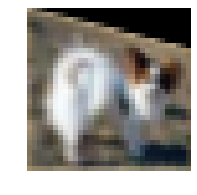

In [50]:
show_image(y[0])

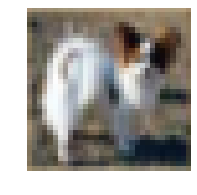

In [51]:
x.show()

In [52]:
#export
def apply_perspective(coords:FlowField, coeffs:Points)->FlowField:
    "Transform `coords` with `coeffs`"
    size = coords.size()
    #compress all the dims expect the last one ang adds ones, coords become N * 3
    coords = coords.view(-1,2)
    #Transform the coeffs in a 3*3 matrix with a 1 at the bottom left
    coeffs = torch.cat([coeffs, FloatTensor([1])]).view(3,3)
    coords = torch.addmm(coeffs[:,2], coords, coeffs[:,:2].t())
    coords.mul_(1/coords[:,2].unsqueeze(1))
    return coords[:,:2].view(size)

In [17]:
%timeit res = apply_perspective(coords, coeffs1)

128 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This version is a bit faster (instead of adding the ones, we do coords = coords * (first two columns).t() + last column

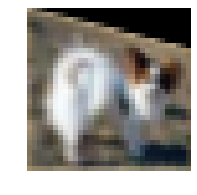

In [53]:
res = apply_perspective(coords, coeffs1)
y = F.grid_sample(x.data[None], res)
show_image(y[0])

## Transforms

First thing we can try, moving all the corners by different bits. We implement this by adding a uniformly distributed random magnitude to each of our four corners.

**Perspective warp**

Maps one 2D quadrilateral into another one by modifying the four coordinates that define it.

_Parameters_

1. **Magnitude** Displacement of each coordinate.

    Domain: Real numbers.
    
2. **Img_size** Size of our image in pixels.

    Domain: Positive integers.

In [54]:
def perspective_warp(c, img_size, magnitude:uniform=0):
    magnitude = magnitude.view(4,2)
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    targ_pts = [[x+m for x,m in zip(xs, ms)] for xs, ms in zip(orig_pts, magnitude)]
    coeffs = find_coeffs(orig_pts, targ_pts)
    return apply_perspective(c, coeffs)

In [55]:
#export
_orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]

def _perspective_warp(c:FlowField, targ_pts:Points):
    "Apply warp to `targ_pts` from `_orig_pts` to `c` `FlowField`"
    return apply_perspective(c, find_coeffs(_orig_pts, targ_pts))

@TfmCoord
def perspective_warp(c, img_size, magnitude:partial(uniform,size=8)=0):
    "Apply warp to `c` and with size `img_size` with `magnitude` amount"

    magnitude = magnitude.view(4,2)
    targ_pts = [[x+m for x,m in zip(xs, ms)] for xs, ms in zip(_orig_pts, magnitude)]
    return _perspective_warp(c, targ_pts)

@TfmCoord
def symmetric_warp(c, img_size, magnitude:partial(uniform,size=4)=0):
    "Apply warp to `c` with size `img_size` and `magnitude` amount"
    m = listify(magnitude, 4)
    targ_pts = [[-1-m[3],-1-m[1]], [-1-m[2],1+m[1]], [1+m[3],-1-m[0]], [1+m[2],1+m[0]]]
    return _perspective_warp(c, targ_pts)

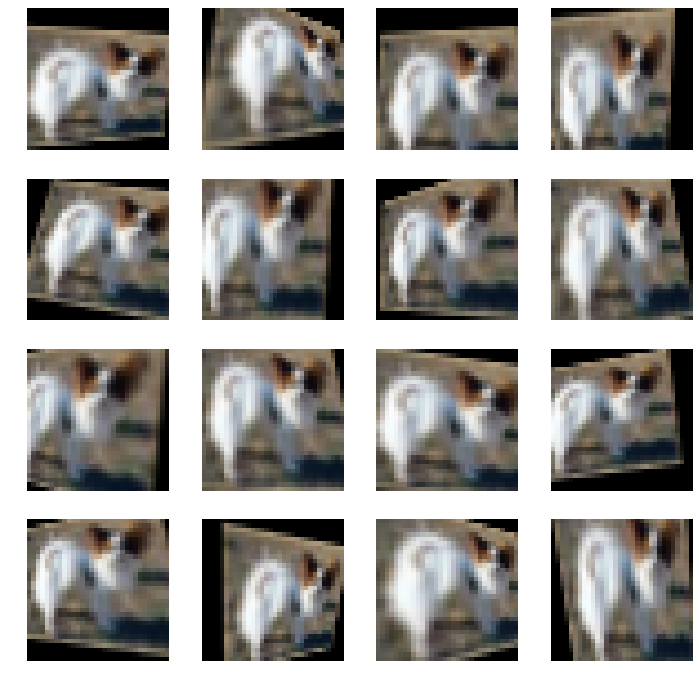

In [56]:
tfm = perspective_warp(magnitude=(-0.4,0.4))
_,axes = plt.subplots(4,4, figsize=(12,12))
for ax in axes.flatten():
    apply_tfms(tfm, x, padding_mode='zeros').show(ax)

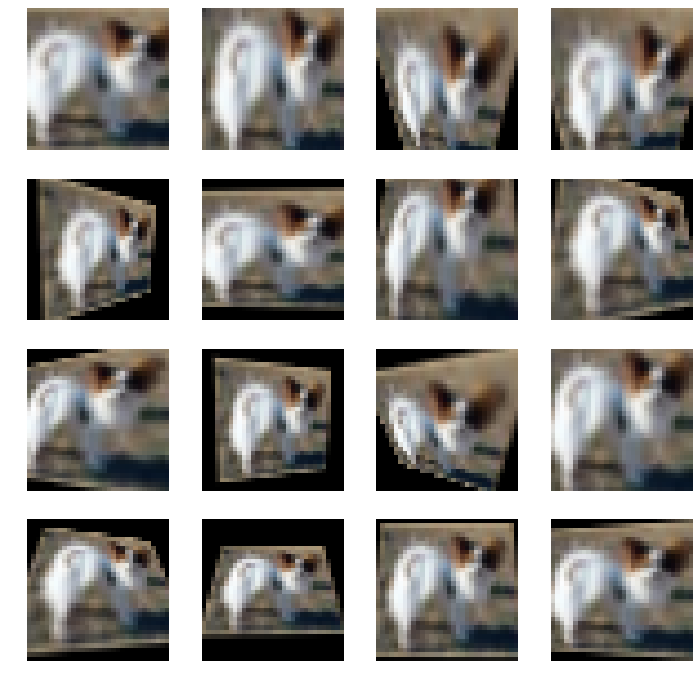

In [57]:
tfm = symmetric_warp(magnitude=(-0.4,0.4))
_,axes = plt.subplots(4,4, figsize=(12,12))
for ax in axes.flatten():
    apply_tfms(tfm, x, padding_mode='zeros').show(ax)

To be a bit less messy, perspective wraps are of two type: tilt and skews. , skew changes one corner only.

**Tilt**

Changes the perspective from where we see the image (on the left, right, top or bottom)

_Parameters_

1. **Magnitude** Displacement of each coordinate.

    Domain: Real numbers.
    
2. **Direction** Direction to where the image must be titled. 0 stands for right, 1 stands for left, 2 stands for top and 3 stands for bottom.

    Domain: [0, 1, 2, 3]
    
3. **Img_size** Size of our image in pixels. 

    Domain: Positive integers.
    
**Skew**   

Skew warps the image by changing one of the coordinates of one corner.

_Parameters_

1. **Magnitude** Displacement of each coordinate.

    Domain: Real numbers.
    
2. **Direction** Direction on how should the image be skewed.

    Domain: [0, 1, 2, 3, 4, 5, 6, 7]
    
3. **Img_size** Size of our image in pixels.

    Domain: Positive integers.

In [58]:
#export
def rand_int(low:int,high:int)->int: return random.randint(low, high)

@TfmCoord
def tilt(c, img_size, direction:rand_int, magnitude:uniform=0):
    "Tilt `c` field and resize to`img_size` with random `direction` and `magnitude`"
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1+magnitude]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1+magnitude,1]]
    elif direction == 3: targ_pts = [[-1-magnitude,-1], [-1,1], [1+magnitude,-1], [1,1]]  
    coeffs = find_coeffs(orig_pts, targ_pts)
    return apply_perspective(c, coeffs)

@TfmCoord
def skew(c, img_size, direction:rand_int, magnitude:uniform=0):
    "Skew `c` field and resize to`img_size` with random `direction` and `magnitude`"
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1-magnitude,-1], [-1,1], [1,-1], [1,1]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1,1]]
    elif direction == 3: targ_pts = [[-1,-1], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 4: targ_pts = [[-1,-1], [-1,1], [1+magnitude,-1], [1,1]]
    elif direction == 5: targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1]]
    elif direction == 6: targ_pts = [[-1,-1], [-1,1], [1,-1], [1+magnitude,1]]
    elif direction == 7: targ_pts = [[-1,-1], [-1,1], [1,-1], [1,1+magnitude]] 
    coeffs = find_coeffs(orig_pts, targ_pts)
    return apply_perspective(c, coeffs)

In [60]:
x = train_ds[-4][0]
x.shape

torch.Size([3, 32, 32])

In [62]:
# img = open_image(DATA_PATH/'caltech101/airplanes/image_0054.jpg')
# img.show()

In [61]:
img=x

The four deterministic tilts, going to the back of the image on the first row, and to the front on the second one.

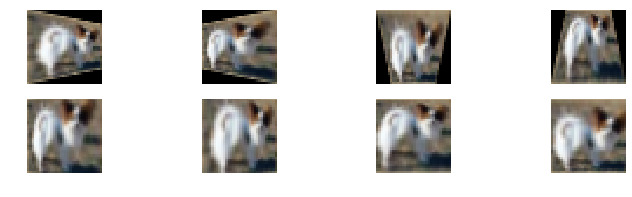

In [63]:
_,axes = plt.subplots(2,4, figsize=(12,3))
for i,ax in enumerate(axes.flatten()):
    magns = [-0.4,0.4]
    tilt(img.clone(), direction=i%4, magnitude=magns[i//4]
        ).set_sample(padding_mode='zeros').show(ax)

The 8 types of skew, again back or front.

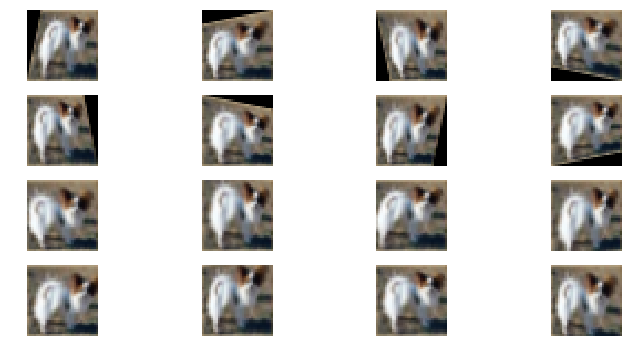

In [64]:
_,axes = plt.subplots(4,4, figsize=(12,6))
for i,ax in enumerate(axes.flatten()):
    magns = [-0.4,0.4]
    skew(img.clone(), direction=i%8, magnitude=magns[i//8]
        ).set_sample(padding_mode='zeros').show(ax)

## Fin